In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
sns.set_style("darkgrid")

In [2]:
# Path for csv files
files_path ='../../raw_data/model_trial/'

# List of files csv
df = pd.read_csv(files_path + 'london_merged.csv',parse_dates=['timestamp'], index_col='timestamp')

In [3]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.shape

(17414, 9)

In [5]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

<Axes: xlabel='timestamp', ylabel='cnt'>

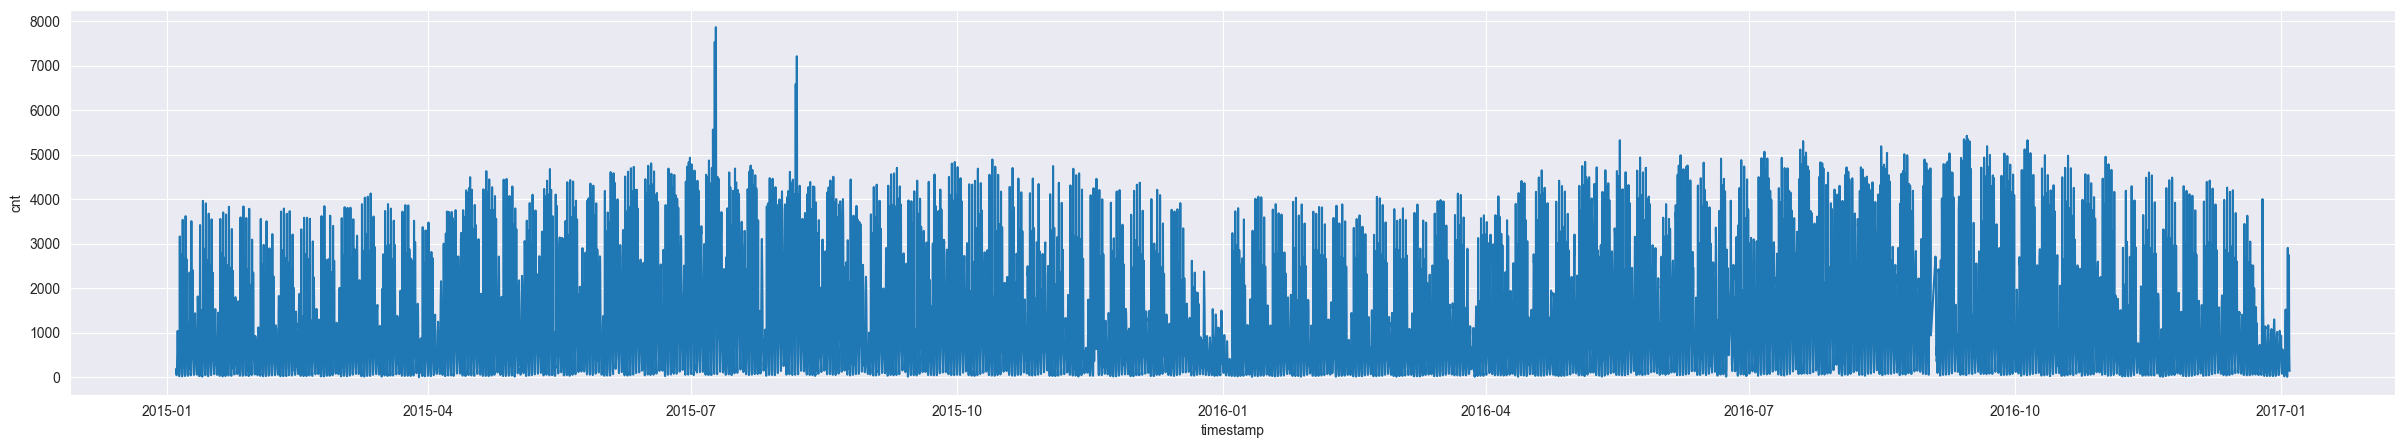

In [6]:
plt.figure(figsize=(30, 5))
sns.lineplot(x=df.index, y='cnt',data=df)

<Axes: xlabel='timestamp', ylabel='cnt'>

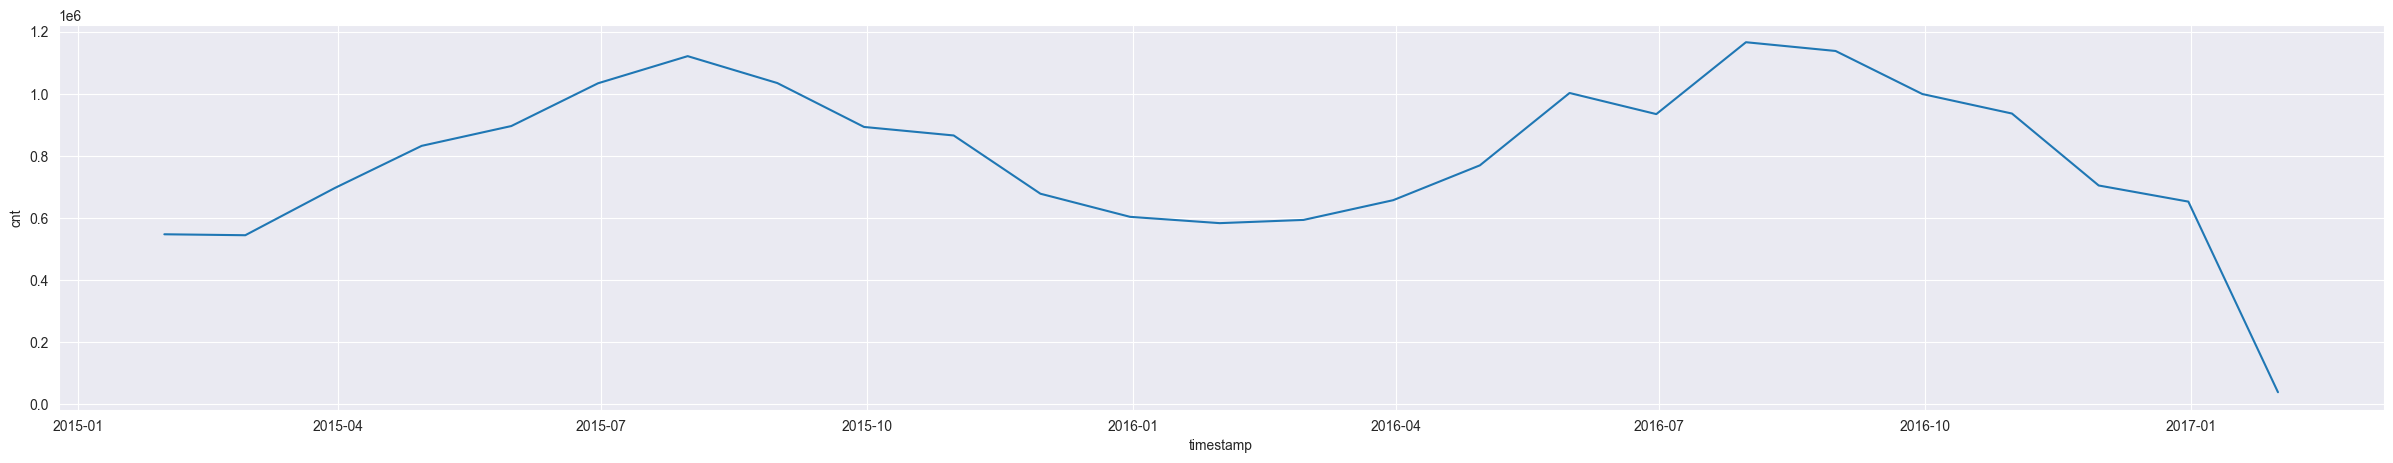

In [7]:
df_by_month = df.resample('M').sum()
plt.figure(figsize=(30,5))
sns.lineplot(x=df_by_month.index, y='cnt',data=df_by_month)

<Axes: xlabel='hour', ylabel='cnt'>

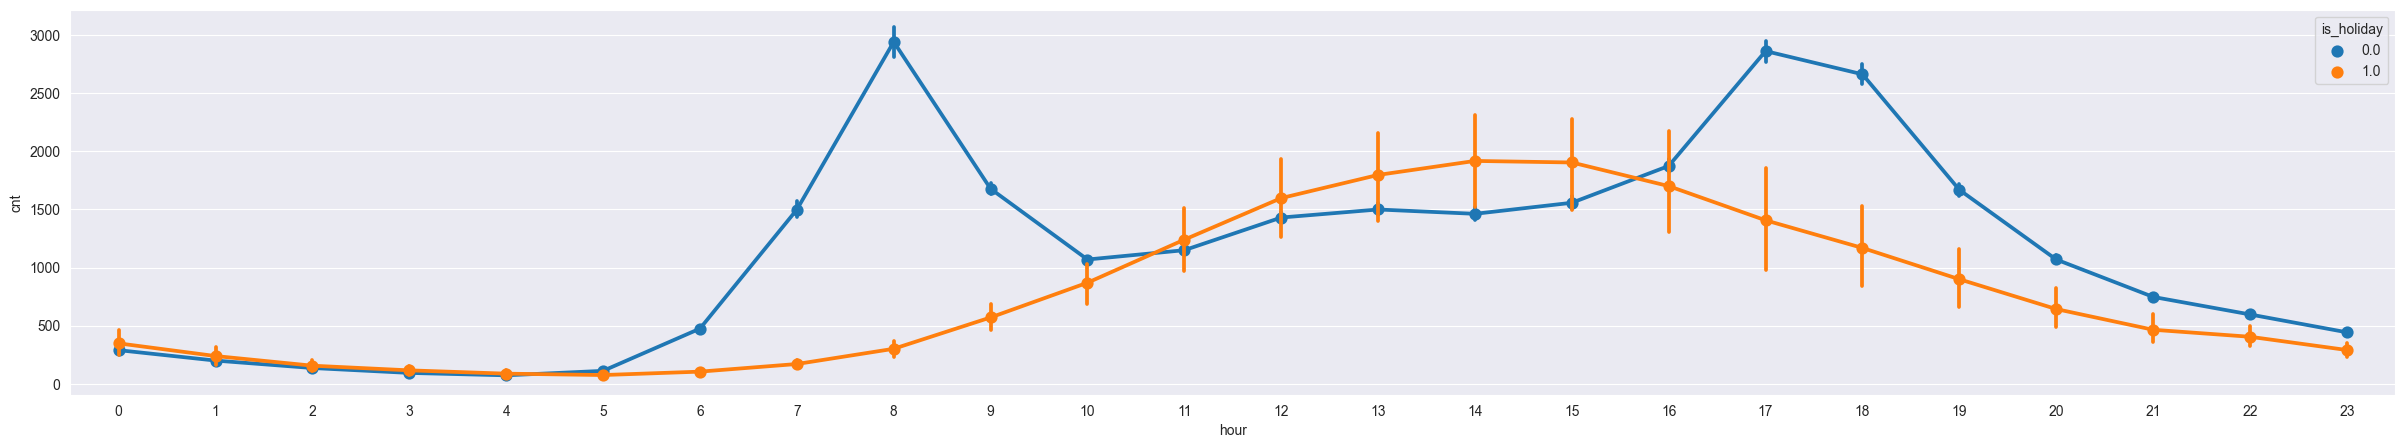

In [8]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='hour', y='cnt',hue='is_holiday',data=df)

<Axes: xlabel='day_of_week', ylabel='cnt'>

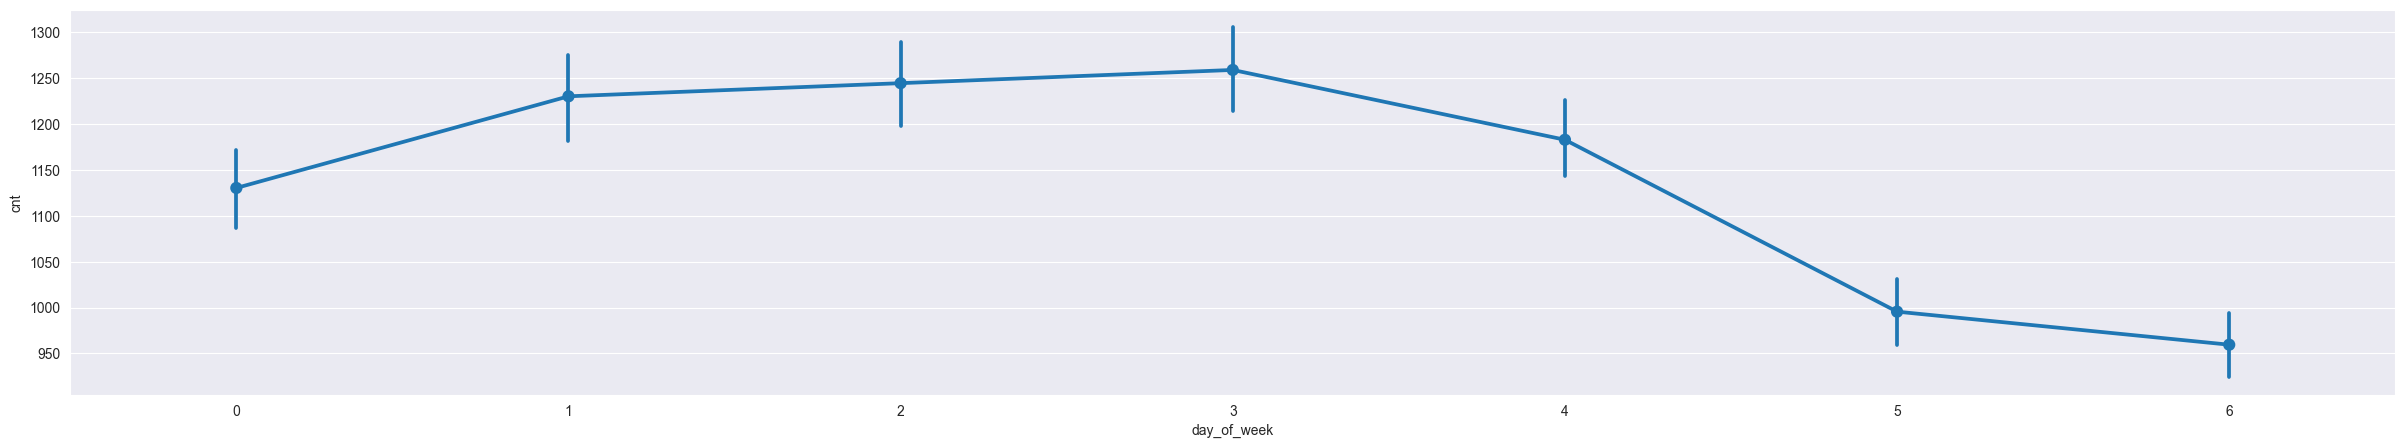

In [9]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='day_of_week', y='cnt',data=df)

In [10]:
# Getting the size of the sets


In [11]:
import math
# Get/Compute the number of rows to train the model on
training_data_len = math.ceil(len(df) *.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [12]:
from sklearn.preprocessing import RobustScaler

In [13]:
# Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_trans = train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
Robust_scale = RobustScaler().fit(train_trans)
train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(train_trans)
test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(test_trans)

In [14]:
#Scale the all of the data from columns ['cnt']
Robust_scale = RobustScaler().fit(train[['cnt']])
train['cnt'] = Robust_scale.transform(train[['cnt']])
test['cnt'] = Robust_scale.transform(test[['cnt']])

/var/folders/l4/v89sdcdj5735tcxsl3t9l82w0000gn/T/ipykernel_55757/1189700782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = Robust_scale.transform(train[['cnt']])
/var/folders/l4/v89sdcdj5735tcxsl3t9l82w0000gn/T/ipykernel_55757/1189700782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cnt'] = Robust_scale.transform(test[['cnt']])


In [15]:
train.to_numpy()
test.to_numpy()

array([[ 0.09573003, -0.625     , -0.57142857, ...,  5.        ,
        22.        , 10.        ],
       [ 0.2899449 , -0.4375    , -0.38095238, ...,  5.        ,
        22.        , 10.        ],
       [ 0.6322314 , -0.1875    , -0.14285714, ...,  5.        ,
        22.        , 10.        ],
       ...,
       [-0.35812672, -0.9375    , -1.0952381 , ...,  1.        ,
         3.        ,  1.        ],
       [-0.43595041, -0.9375    , -1.0952381 , ...,  1.        ,
         3.        ,  1.        ],
       [-0.49449036, -1.        , -1.14285714, ...,  1.        ,
         3.        ,  1.        ]])

In [16]:
time_steps = 24

In [17]:
#Split the data into x_train and y_train data sets
X_train = []
y_train = []

for i in range(len(train) - time_steps):
    X_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [18]:
#Create the x_test and y_test data sets
X_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in range(len(test) - time_steps):
    X_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    #y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [19]:
# [samples, time_steps, n_features]
# Using all 12 columns of data (take out the bike sharing amount column) to make prediction
print('Train data size:')
print(X_train.shape, y_train.shape)
print('Test data size:')
print(X_test.shape, y_test.shape)

Train data size:
(15649, 24, 12) (15649,)
Test data size:
(1741, 24, 12) (1741,)


In [20]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=50,input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dense(35))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(20))
model.add(keras.layers.Dense(15))
model.add(keras.layers.Dense(units=1))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-04 09:34:56.681309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-04 09:34:56.681999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
history = model.fit(X_train, y_train, epochs=5, batch_size=20, validation_split=0.15, shuffle=True)

Epoch 1/5


2023-09-04 09:34:56.834334: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-04 09:34:58.850423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:34:59.172994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:34:59.187692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:35:01.002546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:35:01.022558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - ETA: 0s - loss: 0.3079

2023-09-04 09:35:21.180997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:35:21.282993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:35:21.293455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


666/666 [==============================] - 26s 32ms/step - loss: 0.3079 - val_loss: 0.3264
Epoch 2/5
666/666 [==============================] - 19s 28ms/step - loss: 0.1622 - val_loss: 0.1499
Epoch 3/5
666/666 [==============================] - 19s 28ms/step - loss: 0.0841 - val_loss: 0.0994
Epoch 4/5
666/666 [==============================] - 18s 28ms/step - loss: 0.0580 - val_loss: 0.0809
Epoch 5/5
666/666 [==============================] - 19s 28ms/step - loss: 0.0504 - val_loss: 0.0724


In [22]:
y_pred = model.predict(X_test)
y_pred = Robust_scale.inverse_transform(y_pred)#Undo scaling
y_pred

2023-09-04 09:36:38.161892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:36:38.268138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-04 09:36:38.278280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 2s 17ms/step


array([[ 691.25415 ],
       [1154.6069  ],
       [1442.1411  ],
       ...,
       [  88.6781  ],
       [  25.72168 ],
       [  13.755188]], dtype=float32)

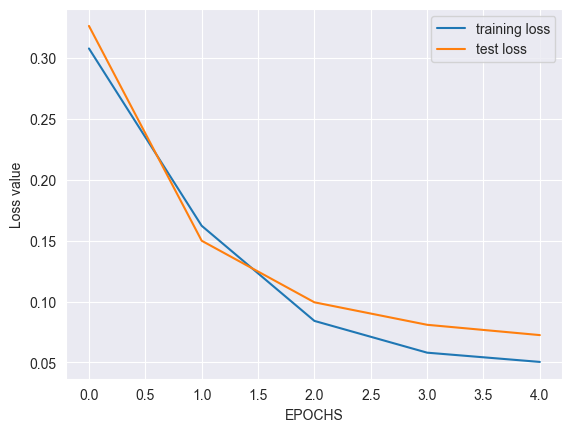

In [23]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

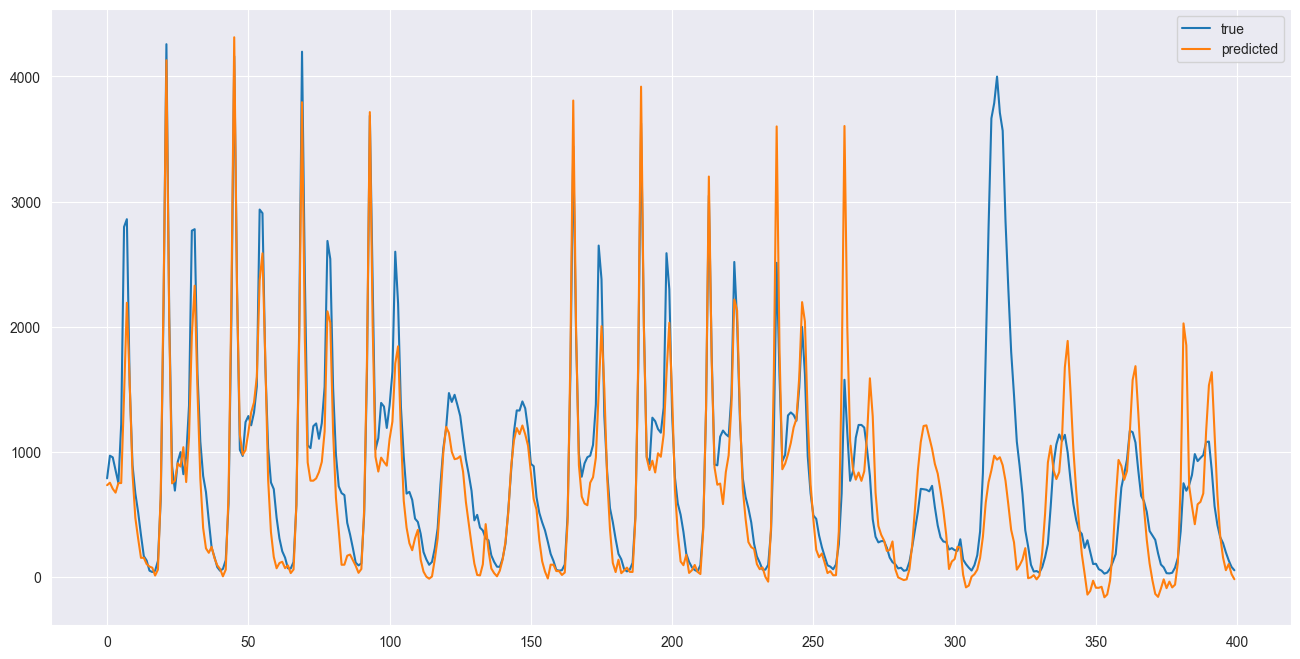

In [24]:
#Pcik some values to zoom in
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1600], label='true')
plt.plot(y_pred[1200:1600], label='predicted')
plt.legend()